In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import Chain_1D_utils as utils
import numpy as np
from sklearn.metrics import confusion_matrix

model_args = {}
model_args['seed'] = 123
model_args['batch_size'] = 128
model_args['lr'] = 5e-3
model_args['momentum'] = .5
model_args['epochs'] = 50
model_args['log_interval'] = 100
model_args['num_classes'] = 5

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, n_samp, n_sub):
        x, y = utils.gen_data(n_samp, n_sub)
        
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [2]:
class VGG16_1D(nn.Module):
    def __init__(self, num_classes=model_args["num_classes"]):
        super(VGG16_1D, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256*62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
def train(model, device, train_loader, optimizer, epochs, log_interval):
    model.train()
    train_losses = []
    for ep in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if batch_idx % (10*log_interval) == 0:
                print(f'Epoch {ep}, Loss: {loss.item():.6f}')
        
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
    
    return train_losses

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    print(f'\nTest set: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10,8))
    plt.imshow(cm)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i][j]),
                    ha="center", va="center",
                    color="white" if cm[i][j] > cm.max() / 2 else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return test_loss, accuracy

In [23]:
def train_with_validation(model, device, train_loader, optimizer, epochs, log_interval, patience=10):
    model.train()
    train_losses = []
    val_losses = []
    
    train_size = int(0.8 * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_subset, val_subset = random_split(train_loader.dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=train_loader.batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=train_loader.batch_size, shuffle=False)
    
    best_val_loss = np.inf
    patience_counter = 0
    for ep in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                epoch_val_loss += F.cross_entropy(output, target).item()
        
        if epoch_val_loss < best_val_loss - 0.001:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {ep}")
                model.load_state_dict(torch.load('best_model.pth'))
                break

        epoch_train_loss /= len(train_loader)
        epoch_val_loss /= len(val_loader)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {ep}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    return train_losses, val_losses

def train_and_evaluate(model_args, data):
    torch.manual_seed(model_args['seed'])
    
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size
    train_dataset, test_dataset = random_split(data, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=model_args['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=model_args['batch_size'], shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VGG16_1D(num_classes=model_args["num_classes"]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=model_args['lr'], weight_decay=1e-3)
    
    train_losses, val_losses = train_with_validation(
        model, device, train_loader, optimizer, model_args['epochs'], model_args['log_interval']
    )
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training/Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    test_loss, test_accuracy = test(model, test_loader, device)
    
    return model, train_losses, val_losses

In [15]:
dataset = ClassificationDataset(n_samp = 100000, n_sub=model_args['num_classes'])

0 --> 0.03345680236816406 s
1000 --> 23.359713554382324 s
2000 --> 56.698771476745605 s
3000 --> 64.38176989555359 s
4000 --> 71.39907312393188 s
5000 --> 81.7690098285675 s
6000 --> 99.0502507686615 s
7000 --> 106.43935561180115 s
8000 --> 116.04709649085999 s
9000 --> 124.7301013469696 s
10000 --> 135.11838722229004 s
11000 --> 143.95141291618347 s
12000 --> 168.0013782978058 s
13000 --> 176.34269070625305 s
14000 --> 182.98006868362427 s
15000 --> 222.39950394630432 s
16000 --> 232.0510687828064 s
17000 --> 241.6066861152649 s
18000 --> 250.58716773986816 s
19000 --> 289.518602848053 s
20000 --> 298.9018874168396 s
21000 --> 309.1133723258972 s
22000 --> 323.18322467803955 s
23000 --> 333.45892214775085 s
24000 --> 344.2990515232086 s
25000 --> 354.1415033340454 s
26000 --> 365.1940746307373 s
27000 --> 372.6383271217346 s
28000 --> 379.5733370780945 s
29000 --> 387.88128113746643 s
30000 --> 395.4718539714813 s
31000 --> 404.52776622772217 s
32000 --> 413.96263670921326 s
33000 -->

Epoch 0: Train Loss: 1.1322, Val Loss: 1.4895
Epoch 1: Train Loss: 0.9251, Val Loss: 4.6695
Epoch 2: Train Loss: 0.7994, Val Loss: 1.5360
Epoch 3: Train Loss: 0.6970, Val Loss: 0.9346
Epoch 4: Train Loss: 0.6321, Val Loss: 0.8836
Epoch 5: Train Loss: 0.5743, Val Loss: 1.8088
Epoch 6: Train Loss: 0.5385, Val Loss: 0.7234
Epoch 7: Train Loss: 0.5009, Val Loss: 4.6507
Epoch 8: Train Loss: 0.4804, Val Loss: 1.5126
Epoch 9: Train Loss: 0.4487, Val Loss: 0.4786
Epoch 10: Train Loss: 0.4257, Val Loss: 0.5075
Epoch 11: Train Loss: 0.4069, Val Loss: 1.5422
Epoch 12: Train Loss: 0.3855, Val Loss: 2.1482
Epoch 13: Train Loss: 0.3714, Val Loss: 0.6957
Epoch 14: Train Loss: 0.3598, Val Loss: 0.6802
Epoch 15: Train Loss: 0.3289, Val Loss: 0.8079
Epoch 16: Train Loss: 0.3081, Val Loss: 0.7480
Epoch 17: Train Loss: 0.3032, Val Loss: 0.4018
Epoch 18: Train Loss: 0.2801, Val Loss: 1.4700
Epoch 19: Train Loss: 0.2720, Val Loss: 0.9447
Epoch 20: Train Loss: 0.2538, Val Loss: 2.0215
Epoch 21: Train Loss: 0

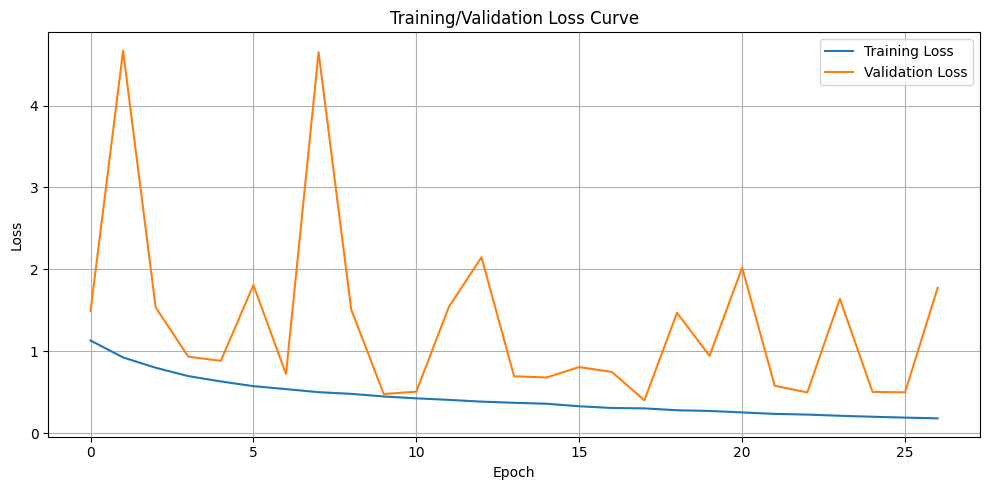


Test set: Avg loss: 0.4034, Accuracy: 16893/20000 (84.47%)



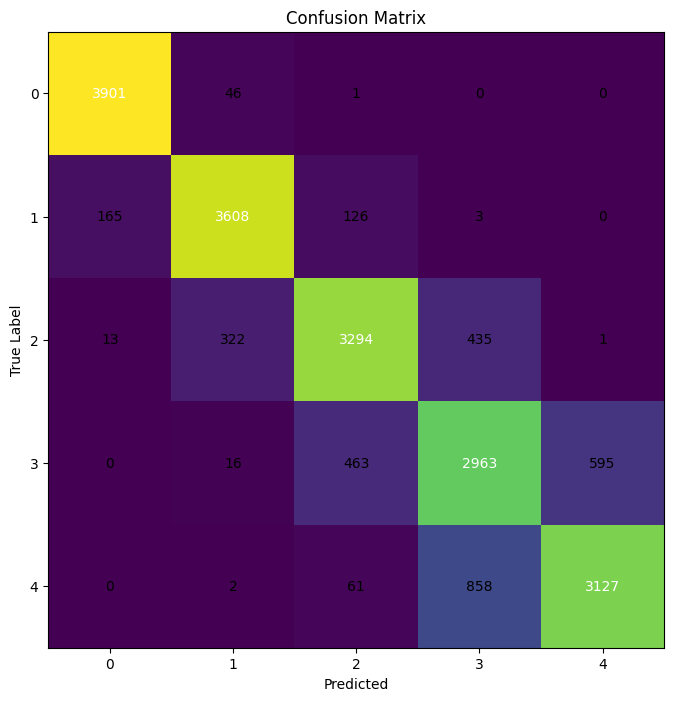

In [28]:
model = train_and_evaluate(model_args=model_args, data=dataset)